In [1]:
import os
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl

from skimage.util import img_as_ubyte
from skimage import io
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import filters
from skimage import segmentation
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage import morphology

import numpy as np
import pandas as pd

In [29]:
#function to show two images (original and filtered) for a given image file
#the determined center and adjusted center (COM) are shown as blue and yellow points, respectively
#the background is shown in red
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.scatter(center[1], center[0], s=10, c='#7fcdbb')
    ax2.scatter(center_COM[1], center_COM[0], s=20, c='#fed976')
    circ_center = plt.Circle((center[1], center[0]), 75, color='#41b6c4', alpha=0.2)
    circ_center_COM = plt.Circle((center_COM[1], center_COM[0]), 30, color='#ffeda0', alpha=0.3)
    circ_bg = plt.Circle((center[1] + 90, center[0] + 90), 20, color='#fc4e2a', alpha=0.5)
    ax2.add_artist(circ_center)
    ax2.add_artist(circ_center_COM)
    ax2.add_artist(circ_bg)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [30]:
#adjust image contrast for viewing
def basic_opening(filepath):
    original = io.imread(filepath, as_gray=True)
    selem = disk(3)
    opened = erosion(original, selem)
    return opened

In [31]:
#function to find the center of image
#normally locates the button area unless there are high intensity spots in the background area
def find_center(filepath):
    opened = basic_opening(filepath)
    
    sum_row = 0
    for i in range(512):
        a = np.sum(opened[i, :])
        if a > sum_row:
            sum_row = a
            row = i
    
    sum_col = 0
    for i in range(512):
        b = np.sum(opened[:, i])
        if b > sum_col:
            sum_col = b
            col = i
    
    return row, col
            

In [32]:
#finds an adjusted button center by calculating the center of mass around the center found using find_center
def find_COM(filepath):
    opened = basic_opening(filepath)
    center = find_center(filepath)
    if center[0] < 475 and center[1] < 475 and center[0] > 37 and center[1] > 37: 
        max_I = np.amax(opened[center[0]-37: center[0]+37, center[1]-37: center[1]+37])
    else:
        max_I = np.amax(opened[center[0]-5: center[0]+5, center[1]-5: center[1]+5])
    
    cut_off = max_I - 2000
    sum_I = 0
    x_sum = 0
    y_sum = 0
    if center[0] < 475 and center[1] < 475 and center[0] > 37 and center[1] > 37:
        for i in range(-37, 37):
            for j in range(-37, 37):
                I_val = opened[center[0]+i, center[1]+j]
                if I_val > cut_off:
                    sum_I = sum_I + I_val
                    x_sum = i * I_val + x_sum
                    y_sum = j * I_val + y_sum
    else:
        for i in range(-10, 10):
            for j in range(-10, 10):
                I_val = opened[center[0]+i, center[1]+j]
                if I_val > cut_off:
                    sum_I = sum_I + I_val
                    x_sum = i * I_val + x_sum
                    y_sum = j * I_val + y_sum
    com_x = round(x_sum / sum_I + center[0], 0)
    com_y = round(y_sum / sum_I + center[1], 0)
    return com_x, com_y


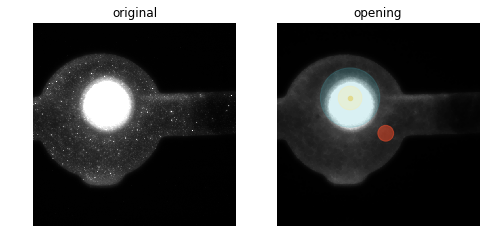

In [36]:
#show example of find_center and find_COM for a single image file
filepath = '/Volumes/EMTEC_C450/part_1_anti_IgG_PE_300ms/part_1_anti_IgG_PE_300msxy001.tif'
center = find_center(filepath)

original = io.imread(filepath, as_gray=True)
selem = disk(3)
opened = erosion(original, selem)
center_COM = find_COM(filepath)

plot_comparison(original, opened, 'opening')

In [37]:
# check file names and make an index for the files
original_directory = r'/Volumes/EMTEC_C450/part_1_anti_IgG_PE_300ms/'
idx = []
for root, dirs, files in os.walk(original_directory):
    for filename in files:
        base, extension = os.path.splitext(filename)
        idx.append(base)
        
name = idx[0]
name_length = len(name)

# file index
idx = []
for root, dirs, files in os.walk(original_directory):
    for filename in files:
        base, extension = os.path.splitext(filename)
        unit = int(base[-3:name_length])
        idx.append(unit)

#check index is correct length
len(idx)

512

In [38]:
# unit cells were imaged in 2 parts (32 x 16, 512 total unit cells)
# analyze all images - part 1
directory = os.fsencode('/Volumes/EMTEC_C450/part_1_anti_IgG_PE_300ms/')
dir_str = os.fsdecode('/Volumes/EMTEC_C450/part_1_anti_IgG_PE_300ms/')
all_medians = np.zeros(512,)
ct = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filepath = os.path.join(dir_str, filename)
    original = io.imread(filepath, as_gray=True)
    center = find_center(filepath) #OR use find_COM
    #signal is the median pixel intensity for a 50 x 50 pixel square
    signal = np.median(original[int(center[0])-25: int(center[0])+25, int(center[1])-25: int(center[1])+25])
    #background is the median pixel intensity for a 20 x 20 pixel square
    #adjust where the background signal is taken here (in relation to the center)
    bg = np.median(original[int(center[0])+90: int(center[0])+110, int(center[1])+90: int(center[1])+110])
    all_medians[ct] = signal - bg
    ct += 1

# re-order according to index -- part 1
all_medians_indexed = np.zeros(512,)
for i in range(512):
    N = idx[i]-1
    all_medians_indexed[N] = all_medians[i]

# re-order for odd/even rows
start_row = []
for i in range(0, 512, 32):
    start_row.append(i)

re_indexed_1 = []
for i in range(16):
    if i % 2 == 0:
        for j in range(32):
            n = start_row[i] + j
            re_indexed_1.append(n)
    if i % 2 == 1:
        for j in range(32):
            n = start_row[i] + 31 - j
            re_indexed_1.append(n)
            
part1_re_indexed = np.zeros(512,)
for i in range(512):
    N = re_indexed_1[i]
    part1_re_indexed[N] = all_medians_indexed[i]

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# analyze all images - part 2
directory = os.fsencode('/Volumes/EMTEC_C450/part_2_anti_IgG_PE_300ms/')
dir_str = os.fsdecode('/Volumes/EMTEC_C450/part_2_anti_IgG_PE_300ms/')
all_medians = np.zeros(512,)
ct = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    filepath = os.path.join(dir_str, filename)
    original = io.imread(filepath, as_gray=True)
    center = find_center(filepath) #OR use find_COM
    #signal is the median pixel intensity for a 50 x 50 pixel square
    signal = np.median(original[int(center[0])-25: int(center[0])+25, int(center[1])-25: int(center[1])+25])
    #background is the median pixel intensity for a 20 x 20 pixel square
    #adjust where the background signal is taken here (in relation to the center)
    bg = np.median(original[int(center[0])+90: int(center[0])+110, int(center[1])+90: int(center[1])+110])
    all_medians[ct] = signal - bg
    ct += 1

# re-order according to index -- part 2
all_medians_indexed = np.zeros(512,)
for i in range(512):
    N = idx[i]-1
    all_medians_indexed[N] = all_medians[i]

# re-order for odd/even rows
start_row = []
for i in range(0, 512, 32):
    start_row.append(i)

re_indexed_2 = []
for i in range(16):
    if i % 2 == 0:
        for j in range(32):
            n = start_row[i] + j
            re_indexed_2.append(n)
    if i % 2 == 1:
        for j in range(32):
            n = start_row[i] + 31 - j
            re_indexed_2.append(n)

part2_re_indexed = np.zeros(512,)
for i in range(512):
    N = re_indexed_2[i]
    part2_re_indexed[N] = all_medians_indexed[i]

In [ ]:
# combine 2 parts - whole_chip array contains the median signal for all unit cells
start_1 = []
start_2 = []
for i in range(0, 1024, 64):
    start_1.append(i)
    start_2.append(i+32)

part_1_idx = []
part_2_idx = []
for i in range(16):
    for j in range(32):
        n1 = start_1[i] + j
        part_1_idx.append(n1)
        n2 = start_2[i] + j
        part_2_idx.append(n2)
        
whole_chip = np.zeros(1024,)
for i in range(512):
    whole_chip[part_1_idx[i]] = part1_re_indexed[i] 
    whole_chip[part_2_idx[i]] = part2_re_indexed[i]
          